# Дерево Регрессия

Признаки (столбцы):  
Возраст - __Age__ : Возраст застрахованного лица (числовой)  
Пол - __Gender__ : Пол застрахованного лица (Категория: Мужской, Женский)  
Годовой доход - __Annual Income__ : Годовой доход застрахованного лица (числовой, асимметричный)  
Семейное положение - __Marital Status__ : Семейное положение застрахованного лица (категория: холост, женат, разведен)  
Количество иждивенцев - __Number of Dependents__ : Количество иждивенцев (числовое, с пропущенными значениями)  
Уровень образования - __Education Level__ : наивысший достигнутый уровень образования (категория: средняя школа, бакалавр, магистр, доктор философии)  
Род занятий - __Occupation__ : Род занятий застрахованного лица (категория: работающий по найму, самозанятый, безработный)  
Оценка состояния здоровья - __Health Score__ : оценка, отражающая состояние здоровья (числовая, асимметричная)  
Местоположение - __Location__ : Тип местоположения (Категория: Город, Пригород, Сельская местность)  
Тип полиса - __Policy Type__ : Тип страхового полиса (Категорийный: Базовый, Комплексный, Премиум)  
Предыдущие заявления - __Previous Claims__ : Количество предыдущих заявлений (числовое, с выбросами)  
Возраст транспортного средства - __Vehicle Age__ : Возраст застрахованного транспортного средства (числовой)  
Кредитный рейтинг - __Credit Score__ : кредитный рейтинг застрахованного лица (числовой, с отсутствующими значениями)  
Срок действия страхового полиса - __Insurance Duration__ : Срок действия страхового полиса (числовой, в годах)  
Дата начала действия полиса - __Policy Start Date__ : Дата начала действия страхового полиса (Текст, неправильно отформатирован)  
Отзывы клиентов - __Customer Feedback__ : краткие отзывы клиентов (текст)  
Статус курения  - __Smoking Status__  : Статус курения застрахованного лица (Категория: Да, Нет)  
Частота упражнений - __Exercise Frequency__ : Частота упражнений (Категория: Ежедневно, Еженедельно, Ежемесячно, Редко)  
Тип недвижимости  - __Property Type__ : Тип собственности (Категория: Дом, Квартира, Кондоминиум)  

Целевая переменная:  
Сумма страховой премии - __Premium Amount__ : целевая переменная, представляющая сумму страховой премии (числовая, асимметричная)  

In [1]:
import time
from glob import glob
import os 
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import root_mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor


from sklearn.preprocessing import  StandardScaler,  MinMaxScaler



print('Виртуальное окружение')
!which python 
# Текущее положение
print('\nТекущее положение: ')
path_1 = os.getcwd()
print(path_1)
print("\nДатасет: ")
!ls dataset

Виртуальное окружение
/home/maksim/anaconda3/envs/rapids-25.02/bin/python

Текущее положение: 
/home/maksim/develops/python/MAKSIM/ML/7_Tree_Regression

Датасет: 
sample_submission.csv  test.csv  train.csv


In [2]:
def cleaning_resource(var_name=None):
    ''' 
        Очистка памяти для указанной переменной
    '''
    import gc
    import sys
    from pympler import asizeof
    if var_name in globals():  # Проверяем, существует ли глобальная переменная
        size1 = asizeof.asizeof(globals()[var_name])  # Измеряем реальный размер
        print(f"Объём переменной: {size1 / (1024**2):.2f} МБ")  # В мегабайтах
        del globals()[var_name]
        print(f"✅ Объект {var_name} удалён")
    elif var_name in locals():  # Проверяем локальную переменную
        size1 = asizeof.asizeof(locals()[var_name])  # Измеряем размер
        print(f"Объём переменной: {size1 / (1024**2):.2f} МБ")  # В мегабайтах
        del locals()[var_name]
        print(f"✅ Локальный объект {var_name} удалён")
    else:
        print(f"⚠️ Переменная {var_name} не найдена, но память очищена")

    gc.collect()  # Очистка памяти


def plot_box_plot(data):
    ''' 
        Построение графиков (ящик с усами)
    '''
    features = data.columns

    num_features = len(features)

    fig, axes = plt.subplots(1, num_features, figsize=(num_features * 3, 10))

    for i, feature in enumerate(features):
        sns.boxplot(y=data[feature], ax=axes[i])
        axes[i].set_title(feature)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

    plt.tight_layout()
    plt.show()



def plot_histogram(data):
    ''' 
        Построение гарфиков  гистограм
    '''
    features = data.columns

    num_features = len(features)
    num_rows = (num_features + 1) // 2  

    fig, axes = plt.subplots(num_rows, 2, figsize=(14, num_rows * 4))
    axes = axes.flatten() 

    for i, feature in enumerate(features):
        sns.histplot(data[feature], kde=True, ax=axes[i])
        axes[i].set_title(f'Распределение признака "{feature}"')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


def plot_histogram_box(data, col='Premium Amount'):
    ''' 
        Функция построения графиков попарно, гистограмма и Ящик с усами
    '''
    # Создаем два графика в одной строке (1 строка, 2 столбца)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))  

    # Гистограмма
    sns.histplot(data[col], bins=30, kde=True, ax=axes[0])
    axes[0].set_title(f'Гистограмма {col}')
    axes[0].set_xlabel(f'{col}')
    axes[0].set_ylabel('Частота')

    # Boxplot (ящик с усами)
    sns.boxplot(x=data[col], ax=axes[1])
    axes[1].set_title(f'Ящик с усами  {col}')
    axes[1].set_xlabel(f'{col}')

    # Показываем оба графика в одном окне
    plt.tight_layout()
    plt.show()
    
    
def plot_histogram_chart(data, col=''):
    ''' 
        Функция построения графиков попарно, гистограмма и круговой
    '''
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))  

    # Гистограмма (countplot)
    sns.countplot(x=data[col], ax=axes[0])
    axes[0].set_title(f'Гистограмма {col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Частота')
    axes[0].tick_params(axis='x', rotation=45)  

    # Pie chart (круговая диаграмма)
    data[col].value_counts().plot.pie(ax=axes[1], autopct='%1.1f%%', startangle=90, cmap='Set3')
    axes[1].set_title(f'Распределение категорий в {col}')
    axes[1].set_ylabel('')  
    # Выводим оба графика
    plt.tight_layout()
    plt.show()
    
    

def plot_analize_data(data1, num_col_del):
    ''' 
        Строит в цикле попарно графики для числовых и категориальных столбцов
    '''
    data = data1.drop(columns=num_col_del, errors='ignore')  
    numeric_columns = data.select_dtypes(include=[np.number])  # Выбираем числовые столбцы

    for col in numeric_columns.columns:
        plot_histogram_box(data, col)
        
        
    categorical_columns = data.select_dtypes(exclude=[np.number])
    

    # Визуализация категориальных признаков
    for col in categorical_columns.columns:
        plot_histogram_chart(data, col)
        
  

def analiz_data(data):
    ''' 
        Анализ данных
    '''
    # Выбираем только числовые столбцы
    numeric_columns = data.select_dtypes(include=[np.number])
    eda_results = pd.DataFrame({
    "Доля пропусков (%)": numeric_columns.isnull().mean() * 100,
    "Максимальное значение": numeric_columns.max(),
    "Минимальное значение": numeric_columns.min(),
    "Среднее значение": numeric_columns.mean(),
    "Медиана": numeric_columns.median(),
    "Дисперсия": numeric_columns.var(),
    "Квантиль 0.1": numeric_columns.quantile(0.1),
    "Квантиль 0.9": numeric_columns.quantile(0.9),
    "Квартиль 1 (25%)": numeric_columns.quantile(0.25),
    "Квартиль 3 (75%)": numeric_columns.quantile(0.75)
    })

    # Выбираем только категориальные столбцы
    categorical_columns = data.select_dtypes(exclude=[np.number])
    # Рассчитываем статистики
    eda_categorical = pd.DataFrame({
        "Доля пропусков (%)": categorical_columns.isnull().mean() * 100,
        "Количество уникальных значений": categorical_columns.nunique(),
        "Наиболее частое значение (мода)": categorical_columns.mode().iloc[0],
        "Частота моды (%)": categorical_columns.apply(lambda x: x.value_counts(normalize=True).iloc[0] * 100)
    })

    # Выводим результаты
    print("Числовые признаки: \n")
    print(eda_results.to_string())
    print("\nКатегориальные признаки: \n")
    print(eda_categorical.to_string())
    
    return numeric_columns, categorical_columns



    

def encode_categorical_features(data):
    """
    Кодирует категориальные признаки:
    - Label Encoding для порядковых категорий (Education Level, Exercise Frequency, Policy Type, Location, Occupation)
    - One-Hot Encoding для номинальных категорий (Gender, Marital Status, Smoking Status)
    """

    # 1. Определяем категории
    ordinal_features = ["Education Level", "Exercise Frequency", "Policy Type", "Location", "Occupation"]  # Порядковые категории
    nominal_features = ["Gender", "Marital Status", "Smoking Status"]  # Номинальные категории

    # 2. Кодируем 'Policy Type' вручную
    policy_mapping = {"Basic": 0, "Comprehensive": 1, "Premium": 2}
    if "Policy Type" in data.columns:
        data["Policy Type"] = data["Policy Type"].map(policy_mapping)
        print("Столбец 'Policy Type' закодирован как:", policy_mapping)

    # 3. Кодируем 'Location' вручную
    location_mapping = {"Rural": 0, "Suburban": 1, "Urban": 2}
    if "Location" in data.columns:
        data["Location"] = data["Location"].map(location_mapping)
        print("Столбец 'Location' закодирован как:", location_mapping)

    # 4. Кодируем 'Occupation' вручную
    occupation_mapping = {"Unemployed": 0, "Self-Employed": 1, "Employed": 2}
    if "Occupation" in data.columns:
        data["Occupation"] = data["Occupation"].map(occupation_mapping)
        print("Столбец 'Occupation' закодирован как:", occupation_mapping)

    # 5. Label Encoding для остальных порядковых переменных
    label_encoders = {}
    for col in ordinal_features:
        if col in data.columns and col not in ["Policy Type", "Location", "Occupation"]:  # Эти уже закодированы вручную
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])
            label_encoders[col] = le  # Сохраняем энкодер (для обратного преобразования)

    # 6. One-Hot Encoding для номинальных переменных
    data = pd.get_dummies(data, columns=nominal_features, drop_first=True)  # drop_first=True уменьшает размерность

    return data, label_encoders


def handle_missing_values(data, threshold=35):
    """
    Обрабатывает пропущенные значения:
    - Удаляет столбцы, если пропусков > threshold%
    - 'Number of Dependents' → 0
    - 'Credit Score' → среднее значение
    - 'Property Type' → 'Apartment' (самая частая категория)
    - 'Property Type' → Кодируем: Apartment=0, Condo=1, House=2
    - Остальные числовые столбцы → медиана
    - Категориальные столбцы → мода
    """

    # Создаём копию, чтобы не менять оригинальные данные
    data = data.copy()

    # 1. Считаем процент пропусков в каждом столбце
    missing_percent = data.isnull().mean() * 100

    # 2. Удаляем столбцы, если пропусков > threshold%
    cols_to_drop = list(missing_percent[missing_percent > threshold].index)
    data.drop(columns=cols_to_drop, inplace=True)
    print(f"Удалены столбцы с более чем {threshold}% пропусков: {cols_to_drop}\n")

    # 3. Заполняем пропуски в "Number of Dependents" значением 0
    if "Number of Dependents" in data.columns:
        data["Number of Dependents"] = data["Number of Dependents"].fillna(0)
        print("Пропуски в 'Number of Dependents' заменены на 0.\n")

    # 4. Заполняем пропуски в "Credit Score" средним значением
    if "Credit Score" in data.columns:
        mean_credit_score = data["Credit Score"].mean()
        data["Credit Score"] = data["Credit Score"].fillna(mean_credit_score)
        print(f"Пропуски в 'Credit Score' заменены на среднее: {mean_credit_score:.2f}\n")

    # 5. Заполняем пропуски в "Property Type"
    if "Property Type" in data.columns:
        data["Property Type"] = data["Property Type"].fillna("House")
        print("Пропуски в 'Property Type' заменены на 'House'.\n")

        # Кодируем 'Property Type' в порядке возрастания
        property_mapping = {"Apartment": 0, "Condo": 1, "House": 2}
        data["Property Type"] = data["Property Type"].map(property_mapping)
        print("Столбец 'Property Type' закодирован: Apartment=0, Condo=1, House=2.\n")

    # 6. Заполняем оставшиеся числовые столбцы медианой
    numeric_columns = data.select_dtypes(include=[np.number]).drop(
        columns=["Number of Dependents", "Credit Score"], errors="ignore"
    )
    data[numeric_columns.columns] = numeric_columns.fillna(numeric_columns.median())

    # 7. Заполняем остальные категориальные столбцы модой
    categorical_columns = data.select_dtypes(exclude=[np.number])
    for col in categorical_columns.columns:
        data[col] = data[col].fillna(data[col].mode().iloc[0])

    return data

   
    
def normalize_data(data, method="standard"):
    """
    Нормализует числовые данные.
    method="standard" → StandardScaler (приводит к среднему 0 и std=1)
    method="minmax" → MinMaxScaler (масштабирует от 0 до 1)
    """

    numeric_columns = data.select_dtypes(include=[np.number]).columns  # Только числовые столбцы
    scaler = StandardScaler() if method == "standard" else MinMaxScaler()

    # Применяем масштабирование только к числовым столбцам
    data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

    return data
    
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = mse ** 0.5
    rmsle_poly = root_mean_squared_log_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "RMSLE": rmsle_poly, "R²": r2}

## 1) Загрузка данных

In [3]:
train_df = pd.read_csv('dataset/train.csv')


train_df = train_df.drop(columns=["id"])

# test_df = pd.read_csv('dataset/test.csv')
# test_df = test_df.drop(columns=["id"])



print('\nРазмер данных: ', train_df.shape)

print(train_df.head().to_string(index=False))

X = train_df.drop(columns=['Premium Amount'])
y = train_df['Premium Amount']
print("\nПропуски:")
train_df.isnull().sum()


Размер данных:  (1200000, 20)
 Age Gender  Annual Income Marital Status  Number of Dependents Education Level    Occupation  Health Score Location   Policy Type  Previous Claims  Vehicle Age  Credit Score  Insurance Duration          Policy Start Date Customer Feedback Smoking Status Exercise Frequency Property Type  Premium Amount
19.0 Female        10049.0        Married                   1.0      Bachelor's Self-Employed     22.598761    Urban       Premium              2.0         17.0         372.0                 5.0 2023-12-23 15:21:39.134960              Poor             No             Weekly         House          2869.0
39.0 Female        31678.0       Divorced                   3.0        Master's           NaN     15.569731    Rural Comprehensive              1.0         12.0         694.0                 2.0 2023-06-12 15:21:39.111551           Average            Yes            Monthly         House          1483.0
23.0   Male        25602.0       Divorced                

Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Policy Start Date            0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
dtype: int64

## 2) Анализ

In [4]:
# Оставляем только числовые столбцы
numeric_data = train_df.select_dtypes(include=[np.number])

# Вычисляем статистики
statistics = {
    "Доля пропусков": train_df.isnull().mean(),
    "Максимум": numeric_data.max(),
    "Минимум": numeric_data.min(),
    "Среднее": numeric_data.mean(),
    "Медиана": numeric_data.median(),
    "Дисперсия": numeric_data.var(),
    "Квантиль 0.1": numeric_data.quantile(0.1),
    "Квантиль 0.9": numeric_data.quantile(0.9),
    "Квартиль 1": numeric_data.quantile(0.25),
    "Квартиль 3": numeric_data.quantile(0.75),
}

statistics_df = pd.DataFrame(statistics)
print(statistics_df.to_string())

                      Доля пропусков       Максимум     Минимум       Среднее       Медиана     Дисперсия  Квантиль 0.1  Квантиль 0.9   Квартиль 1    Квартиль 3
Age                     1.558750e-02      64.000000   18.000000     41.145563     41.000000  1.833302e+02     22.000000     60.000000    30.000000     53.000000
Annual Income           3.745750e-02  149997.000000    1.000000  32745.217777  23911.000000  1.035521e+09   2627.000000  81075.000000  8001.000000  44634.000000
Credit Score            1.149017e-01     849.000000  300.000000    592.924350    595.000000  2.249458e+04    383.000000    792.000000   468.000000    721.000000
Customer Feedback       6.485333e-02            NaN         NaN           NaN           NaN           NaN           NaN           NaN          NaN           NaN
Education Level         0.000000e+00            NaN         NaN           NaN           NaN           NaN           NaN           NaN          NaN           NaN
Exercise Frequency      0.000000e+

In [5]:
numeric_columns, categorical_columns = analiz_data(train_df)

Числовые признаки: 

                      Доля пропусков (%)  Максимальное значение  Минимальное значение  Среднее значение       Медиана     Дисперсия  Квантиль 0.1  Квантиль 0.9  Квартиль 1 (25%)  Квартиль 3 (75%)
Age                             1.558750              64.000000             18.000000         41.145563     41.000000  1.833302e+02     22.000000     60.000000         30.000000         53.000000
Annual Income                   3.745750          149997.000000              1.000000      32745.217777  23911.000000  1.035521e+09   2627.000000  81075.000000       8001.000000      44634.000000
Number of Dependents            9.139333               4.000000              0.000000          2.009934      2.000000  2.008846e+00      0.000000      4.000000          1.000000          3.000000
Health Score                    6.173000              58.975914              2.012237         25.613908     24.578648  1.489245e+02      9.936849     43.281339         15.918959         34.527209

## 3) Подготовка датасета

In [6]:
# Очистка от пропусков 
train_data_encoded = handle_missing_values(train_df)
num_col_del = ['id']

Удалены столбцы с более чем 35% пропусков: []

Пропуски в 'Number of Dependents' заменены на 0.

Пропуски в 'Credit Score' заменены на среднее: 592.92

Пропуски в 'Property Type' заменены на 'House'.

Столбец 'Property Type' закодирован: Apartment=0, Condo=1, House=2.



In [7]:
# Закодируем категориальные столбцы
train_data_encoded, label_encoders = encode_categorical_features(train_data_encoded)


print(train_data_encoded.head().to_string())

Столбец 'Policy Type' закодирован как: {'Basic': 0, 'Comprehensive': 1, 'Premium': 2}
Столбец 'Location' закодирован как: {'Rural': 0, 'Suburban': 1, 'Urban': 2}
Столбец 'Occupation' закодирован как: {'Unemployed': 0, 'Self-Employed': 1, 'Employed': 2}
    Age  Annual Income  Number of Dependents  Education Level  Occupation  Health Score  Location  Policy Type  Previous Claims  Vehicle Age  Credit Score  Insurance Duration           Policy Start Date Customer Feedback  Exercise Frequency  Property Type  Premium Amount  Gender_Male  Marital Status_Married  Marital Status_Single  Smoking Status_Yes
0  19.0        10049.0                   1.0                0           1     22.598761         2            2              2.0         17.0     372.00000                 5.0  2023-12-23 15:21:39.134960              Poor                   3              2          2869.0        False                    True                  False               False
1  39.0        31678.0                   3.

In [8]:
train_data_encoded["Policy Start Date"] = pd.to_datetime(train_data_encoded["Policy Start Date"])

# Извлекаем только год
train_data_encoded["Policy Start Date"] = train_data_encoded["Policy Start Date"].dt.year  

# Сортируем список уникальных годов
unique_years = sorted(train_data_encoded["Policy Start Date"].unique())

# Создаём словарь для кодирования годов
year_mapping = {year: idx for idx, year in enumerate(unique_years)}

# Применяем замену
train_data_encoded["Policy Start Date"] = train_data_encoded["Policy Start Date"].map(year_mapping)

# Проверяем результат
print(train_data_encoded[["Policy Start Date"]].head())
print(f"Годы закодированы следующим образом: {year_mapping}")

# Определяем правильный порядок для категорий
feedback_mapping = {
    "Average": 1,
    "Good": 2,
    "Poor": 0
}

# Применяем mapping
train_data_encoded["Customer Feedback"] = train_data_encoded["Customer Feedback"].map(feedback_mapping)

# Проверяем результат
print(train_data_encoded["Customer Feedback"].head())


   Policy Start Date
0                  4
1                  4
2                  4
3                  5
4                  2
Годы закодированы следующим образом: {np.int32(2019): 0, np.int32(2020): 1, np.int32(2021): 2, np.int32(2022): 3, np.int32(2023): 4, np.int32(2024): 5}
0    0
1    1
2    2
3    0
4    0
Name: Customer Feedback, dtype: int64


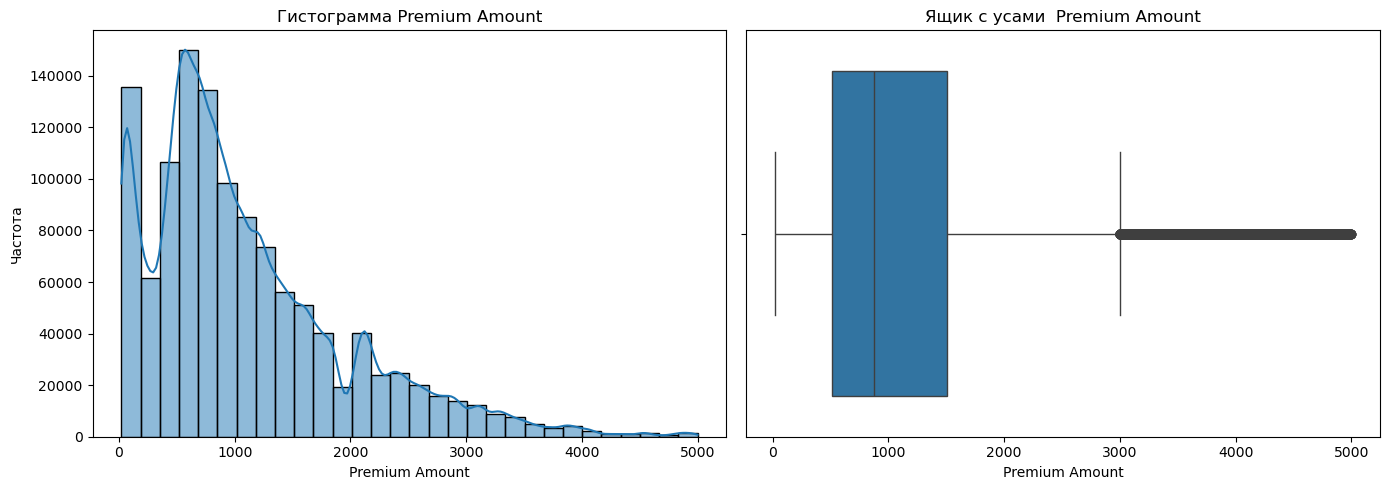

Количество строк после удаления выбросов: 1015992


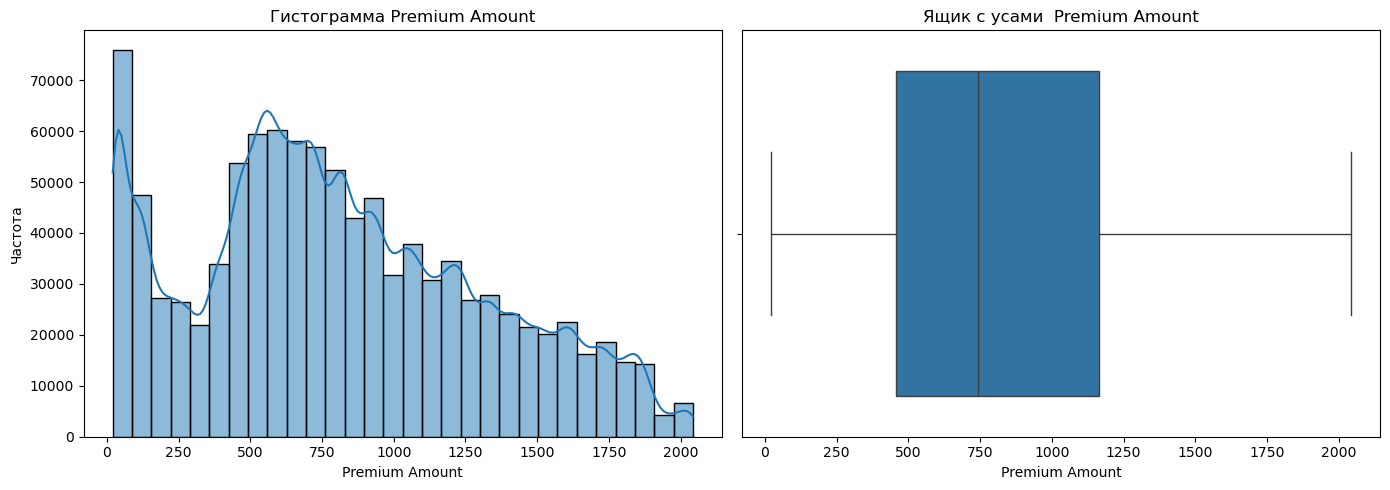

In [9]:
plot_histogram_box(train_data_encoded)

# Находим выбросы в Premium Amount с помощью IQR
Q1 = train_data_encoded["Premium Amount"].quantile(0.35)
Q3 = train_data_encoded["Premium Amount"].quantile(0.65)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Удаляем выбросы
train_data_encoded = train_data_encoded[(train_data_encoded["Premium Amount"] >= lower_bound) & 
                                        (train_data_encoded["Premium Amount"] <= upper_bound)]

# Проверяем размер после удаления выбросов
print(f"Количество строк после удаления выбросов: {train_data_encoded.shape[0]}")

plot_histogram_box(train_data_encoded)


In [10]:
# Проверим выбросы в других числовых столбцах с использованием IQR
for col in numeric_columns.columns:
    Q1 = train_data_encoded[col].quantile(0.25)
    Q3 = train_data_encoded[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.2 * IQR
    
    # Удаляем выбросы
    train_data_encoded = train_data_encoded[(train_data_encoded[col] >= lower_bound) & 
                                             (train_data_encoded[col] <= upper_bound)]
    
    print(f"Обработаны выбросы в столбце {col}.")
    
print(train_data_encoded.shape)

numeric_columns, categorical_columns = analiz_data(train_data_encoded)

Обработаны выбросы в столбце Age.
Обработаны выбросы в столбце Annual Income.
Обработаны выбросы в столбце Number of Dependents.
Обработаны выбросы в столбце Health Score.
Обработаны выбросы в столбце Previous Claims.
Обработаны выбросы в столбце Vehicle Age.
Обработаны выбросы в столбце Credit Score.
Обработаны выбросы в столбце Insurance Duration.
Обработаны выбросы в столбце Premium Amount.
(887902, 21)
Числовые признаки: 

                      Доля пропусков (%)  Максимальное значение  Минимальное значение  Среднее значение       Медиана     Дисперсия  Квантиль 0.1  Квантиль 0.9  Квартиль 1 (25%)  Квартиль 3 (75%)
Age                                  0.0              64.000000             18.000000         41.163250     41.000000  1.805014e+02     22.000000      60.00000         30.000000         53.000000
Annual Income                        0.0           84751.000000              2.000000      24866.337348  21258.000000  3.950335e+08   2689.000000   53471.00000       8056.000000

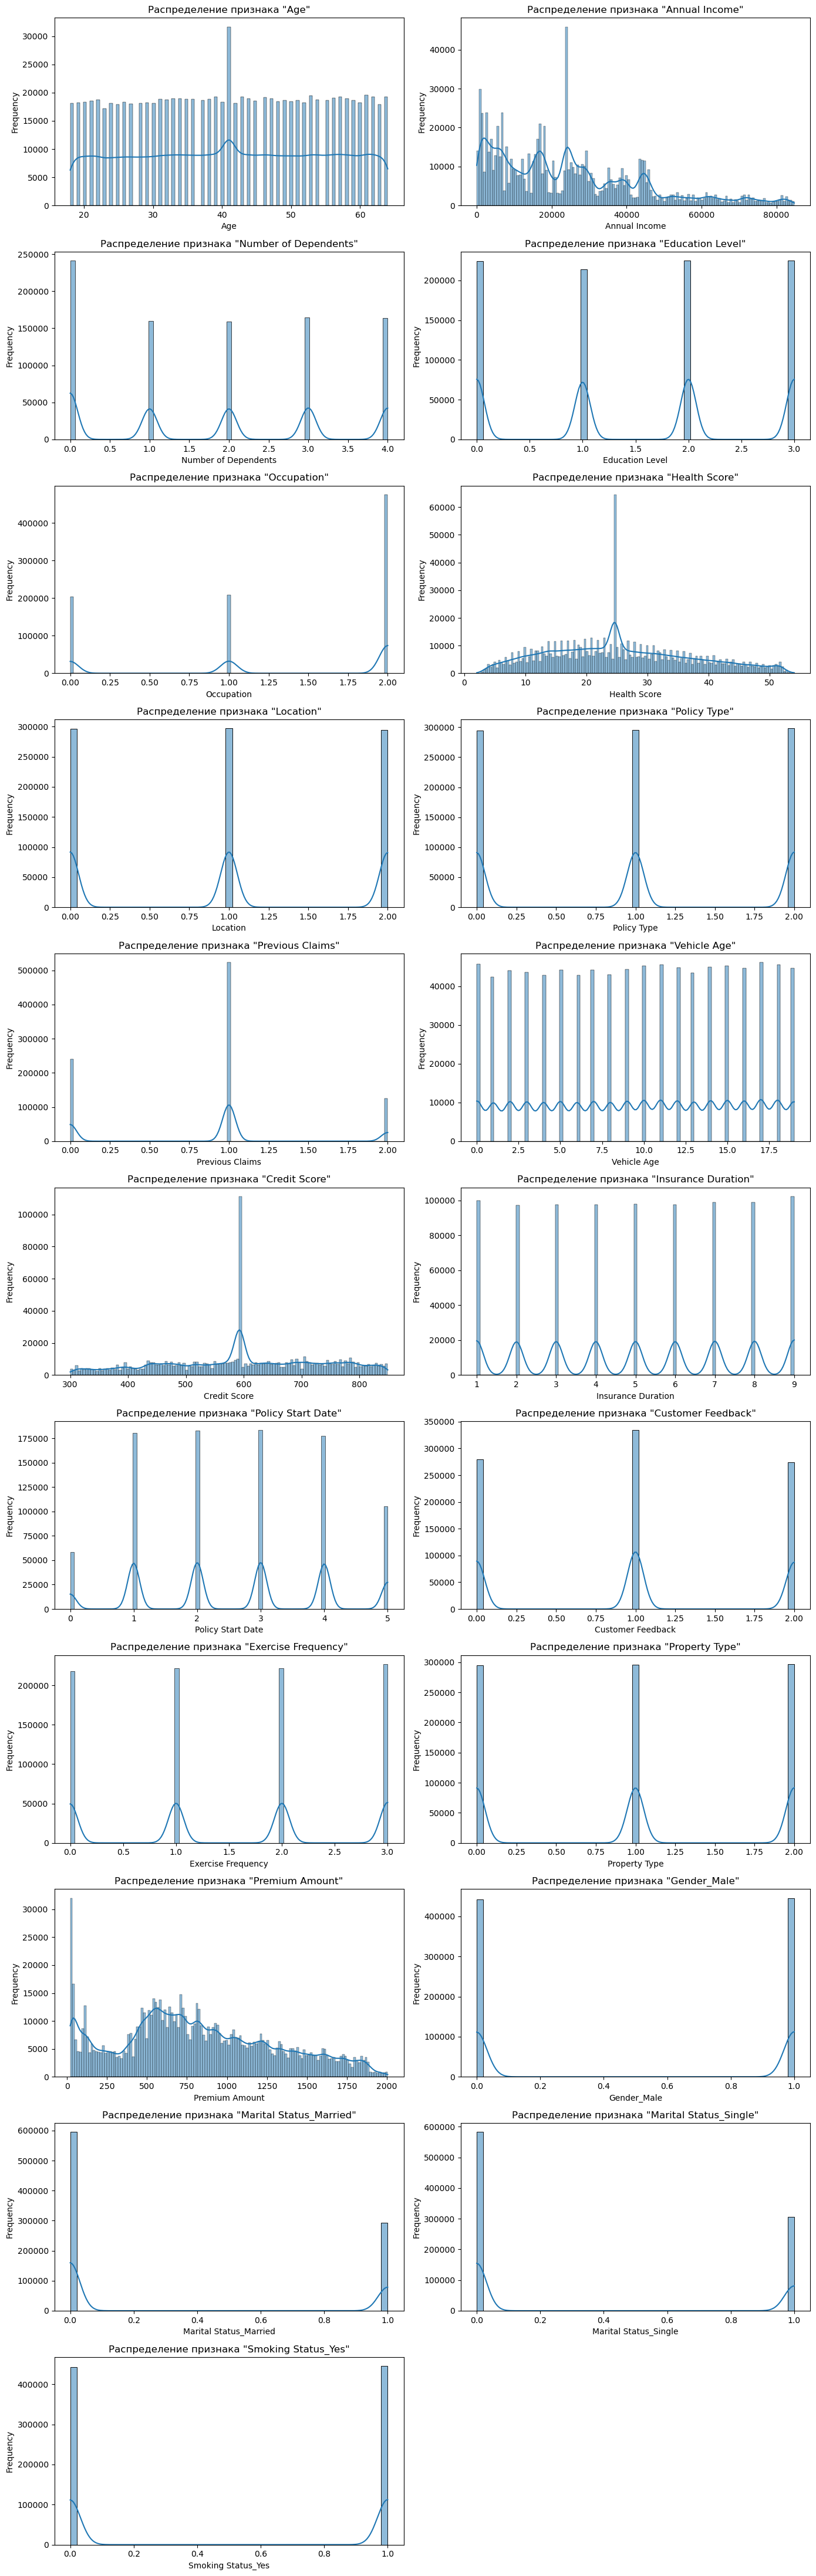

In [11]:
plot_histogram(train_data_encoded)

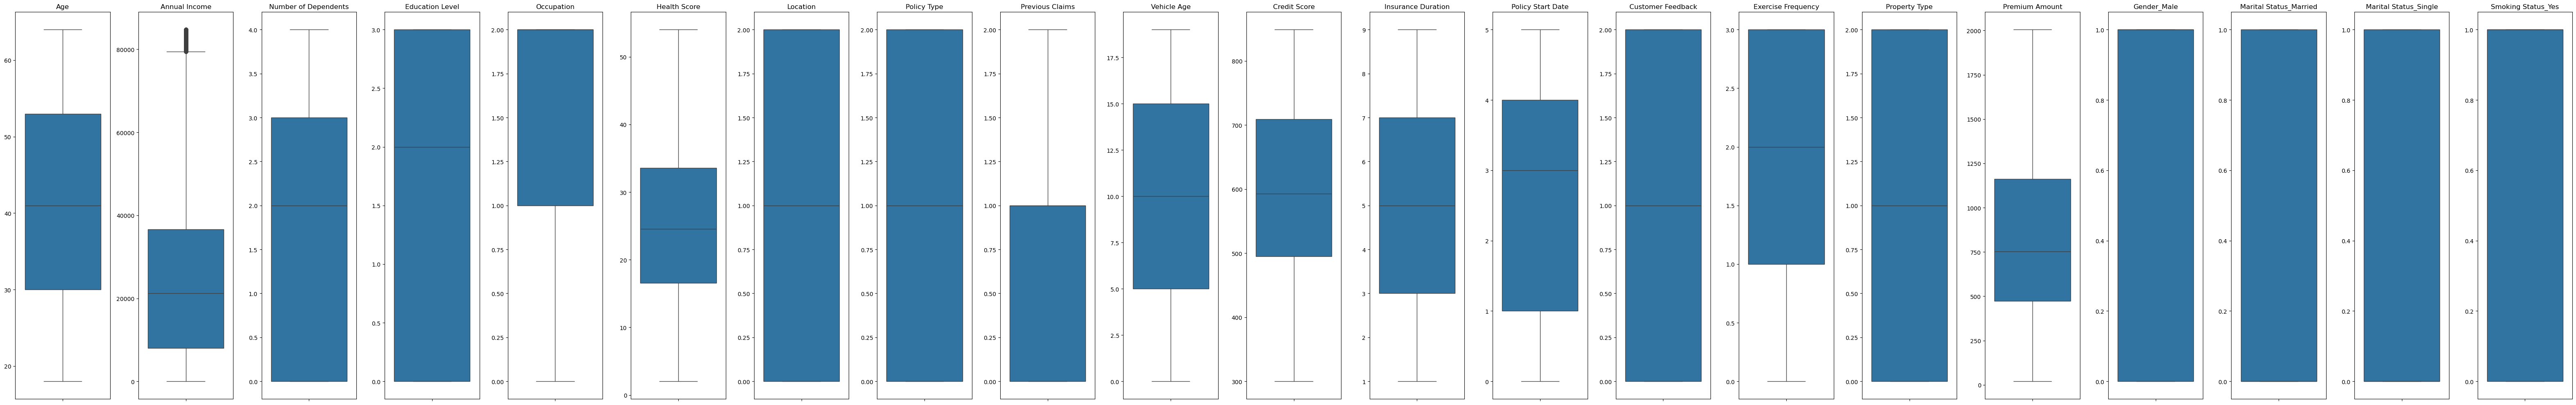

In [12]:
plot_box_plot(train_data_encoded)

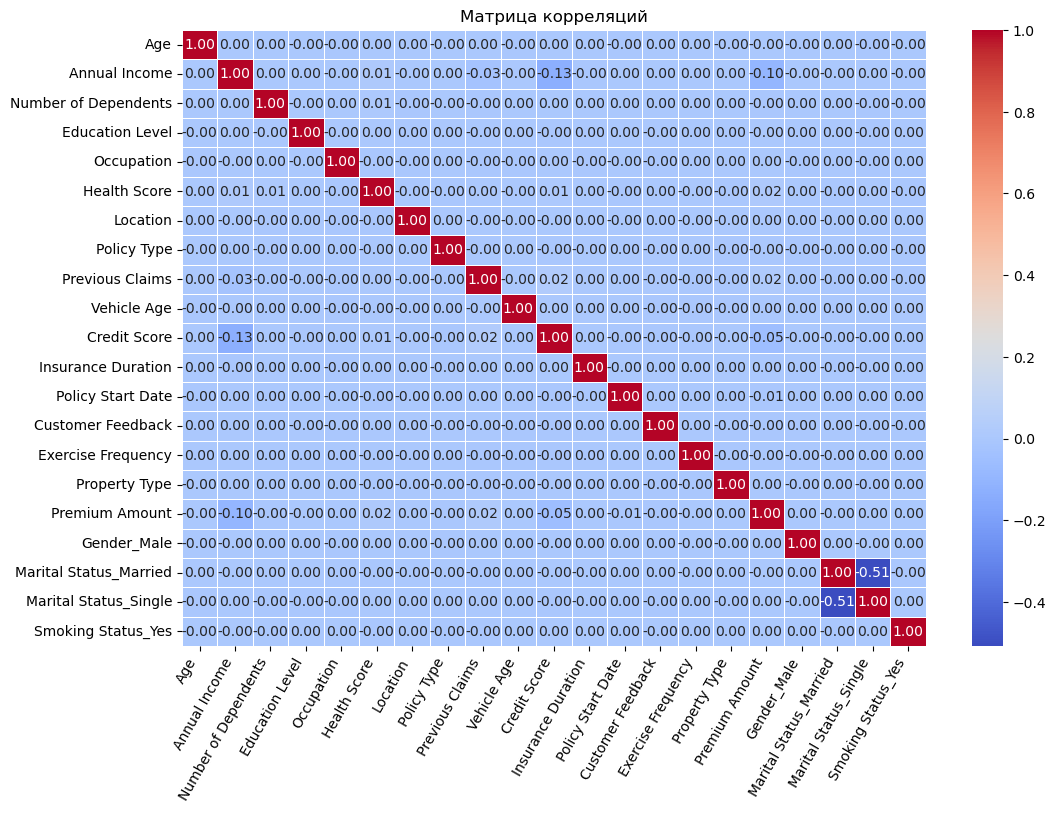

Annual Income            -0.098961
Credit Score             -0.054600
Policy Start Date        -0.006753
Number of Dependents     -0.002307
Policy Type              -0.001723
Customer Feedback        -0.001356
Education Level          -0.001029
Age                      -0.000750
Exercise Frequency       -0.000239
Marital Status_Married   -0.000088
Gender_Male               0.000133
Smoking Status_Yes        0.001311
Vehicle Age               0.001582
Insurance Duration        0.001677
Location                  0.001855
Occupation                0.001970
Marital Status_Single     0.002542
Property Type             0.002912
Health Score              0.015481
Previous Claims           0.017265
Premium Amount            1.000000
Name: Premium Amount, dtype: float64


In [13]:


# Корреляция
corr_matrix = train_data_encoded.corr()

# Визуализируем корреляционную матрицу
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Матрица корреляций")
plt.xticks(rotation=60, ha='right')  
plt.yticks(rotation=0) 
plt.show()


# Выбираем корреляцию с целевой переменной
target_corr = corr_matrix["Premium Amount"].sort_values(ascending=True)

# Выводим признаки, которые наиболее связаны с Premium Amount
print(target_corr)

## 4) Обучение

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
import time

X = train_data_encoded.drop(columns=["Premium Amount"])  
y = train_data_encoded["Premium Amount"]               

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeRegressor(random_state=42)

start_time = time.time()
model.fit(X_train, y_train)
training_time = time.time() - start_time

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_value = rmsle(y_test, y_pred)

# Вывод результатов
print(f'Время обучения: {training_time:.4f} секунд')
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'RMSLE: {rmsle_value:.2f}')
print(f'R^2: {r2:.2f}')



Время обучения: 9.8311 секунд
MAE: 516.52
MSE: 438590.09
RMSE: 662.26
RMSLE: 1.32
R^2: -0.83


In [15]:
selected_features = target_corr[abs(target_corr) > 0.01].index.tolist()
selected_features.remove("Premium Amount")  # Исключаем целевую переменную


X = train_data_encoded[selected_features]
y = train_data_encoded["Premium Amount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeRegressor(random_state=42)

start_time = time.time()
model.fit(X_train, y_train)
training_time = time.time() - start_time

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_value = rmsle(y_test, y_pred)

# Вывод результатов
print(f'Время обучения: {training_time:.4f} секунд')
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'RMSLE: {rmsle_value:.2f}')
print(f'R^2: {r2:.2f}')

Время обучения: 5.0230 секунд
MAE: 503.46
MSE: 423580.60
RMSE: 650.83
RMSLE: 1.30
R^2: -0.77


## 5)  Оценка

Алгоритм KNN показал лучший результат (и по оценке в Kaggle)

## 6) Подбор Гиперпараметров 

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import time

param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

model = DecisionTreeRegressor(random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

# Лучшие параметры
best_params = grid_search.best_params_
print(f'Лучшие параметры: {best_params}')

# Обучение модели с лучшими параметрами
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# Оценка качества модели
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmsle_value = rmsle(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'RMSLE: {rmsle_value:.4f}')
print(f'R^2: {r2:.4f}')
print(f'Время обучения: {end_time - start_time:.2f} секунд')


Лучшие параметры: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
MAE: 370.24
MSE: 213451.05
RMSE: 462.01
RMSLE: 0.9714
R^2: 0.1103
Время обучения: 166.19 секунд


#### Для сравнения с предыдущими моделями нормируем данные

In [ ]:

yyt = y_test**(1/3)
yyp = y_pred**(1/3)

# Оценка качества модели
mae = mean_absolute_error(yyt, yyp)
mse = mean_squared_error(yyt, yyp)
rmse = np.sqrt(mse)
rmsle_value = rmsle(yyt, yyp)
r2 = r2_score(yyt, yyp)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'RMSLE: {rmsle_value:.4f}')
print(f'R^2: {r2:.4f}')
print(f'Время обучения: {end_time - start_time:.2f} секунд')

MAE: 1.64
MSE: 4.85
RMSE: 2.20
RMSLE: 0.2792
R^2: 0.1073
Время обучения: 166.19 секунд


##### Сравнение с лучшей ранее моделью 

__KNN__  
Время обучения KNN на GPU : 0.0092 sec  
MAE: 1.6794  
MSE: 4.8611  
RMSE: 2.2048  
RMSLE: 0.2755  
R² Score: 0.1057  

__Tree__  
Время обучения: Tree 166.19 секунд  
MAE: 1.64  
MSE: 4.85  
RMSE: 2.20  
RMSLE: 0.2792  
R^2: 0.1073  

##### Дерево решений показало немного лучший результат чем KNN 